In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [27]:
transformations = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [56]:
train_dataset = datasets.Food101(root='./data', transform=transformations, download=True, split='train')

test_dataset = datasets.Food101(root='./data', transform=transformations, download=True, split='test')


In [29]:
len(train_dataset), len(test_dataset)

(75750, 25250)

In [57]:
class_names = train_dataset.classes
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [63]:
from torch.utils.data import Subset

selected_classes = ['apple_pie', 'baby_back_ribs', 'baklava',
                    'beef_carpaccio', 'beef_tartare', 'beet_salad',
                    'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


selected_indices = [train_dataset.class_to_idx[class_name] for class_name in selected_classes]


indices_to_keep_train = [i for i, (_, label) in enumerate(train_dataset) if label in selected_indices]
train_dataset = Subset(train_dataset, indices_to_keep_train)

indices_to_keep_test = [i for i, (_, label) in enumerate(test_dataset) if label in selected_indices]
test_dataset = Subset(test_dataset, indices_to_keep_test)

print(f"Number of samples in the filtered datasets: {len(train_dataset), len(test_dataset)}")


Number of samples in the filtered datasets: (7500, 2500)


In [64]:
calibration_size = int(0.02*len(train_dataset))
remaining_size = len(train_dataset) - calibration_size

calibration_set, train_set = random_split(train_dataset, [calibration_size, remaining_size])

In [65]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
calibration_loader = DataLoader(calibration_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [66]:
class model1(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units*2,
                  out_channels=hidden_units*4,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*4,
                  out_channels=hidden_units*8,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(16384, 256),
        nn.ReLU(),
        nn.Linear(256, out_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = model1(3, 8, 10).to(device)


In [67]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [68]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer, accuracy_function):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))

In [70]:
for epoch in range(10):
  loss, acc = train_function(model, device, train_loader, loss_fn, optimizer, accuracy_function)
  print(f'epoch: {epoch+1} | loss: {loss:.4f} | accuracy: {acc:.4f}%')

  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 1 | loss: 0.9626 | accuracy: 66.7564%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 2 | loss: 0.7443 | accuracy: 74.2083%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 3 | loss: 0.6084 | accuracy: 79.2848%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 4 | loss: 0.5097 | accuracy: 83.0052%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 5 | loss: 0.3830 | accuracy: 87.2777%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 6 | loss: 0.3175 | accuracy: 89.6084%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 7 | loss: 0.2999 | accuracy: 90.5459%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 8 | loss: 0.2287 | accuracy: 92.4185%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 9 | loss: 0.2039 | accuracy: 93.2152%


  0%|          | 0/230 [00:00<?, ?it/s]

epoch: 10 | loss: 0.1997 | accuracy: 93.9884%


In [71]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calibration_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [72]:
n = len(calibration_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.99998593

In [73]:
import random
#select 10 indices from the test_data
test_indices = list(range(len(test_dataset)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(test_dataset, selected_indices)

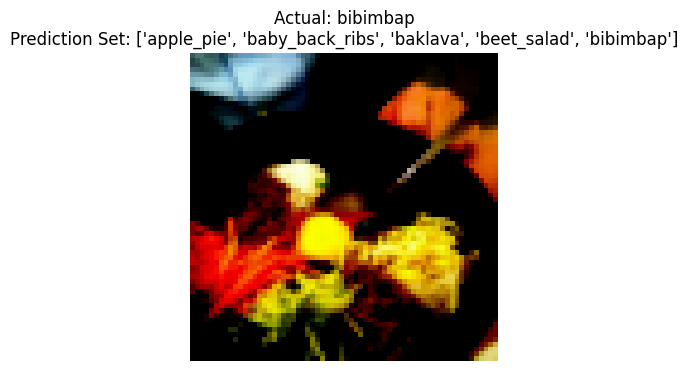

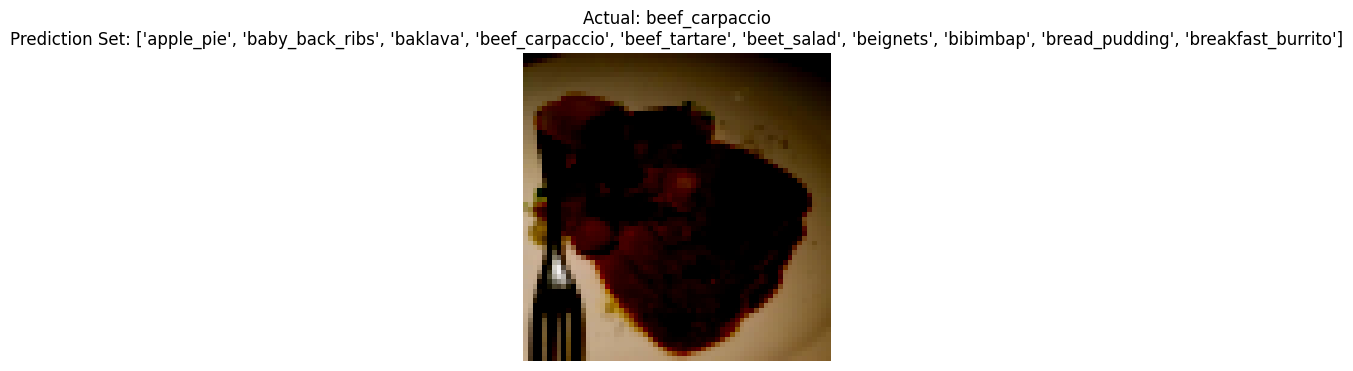

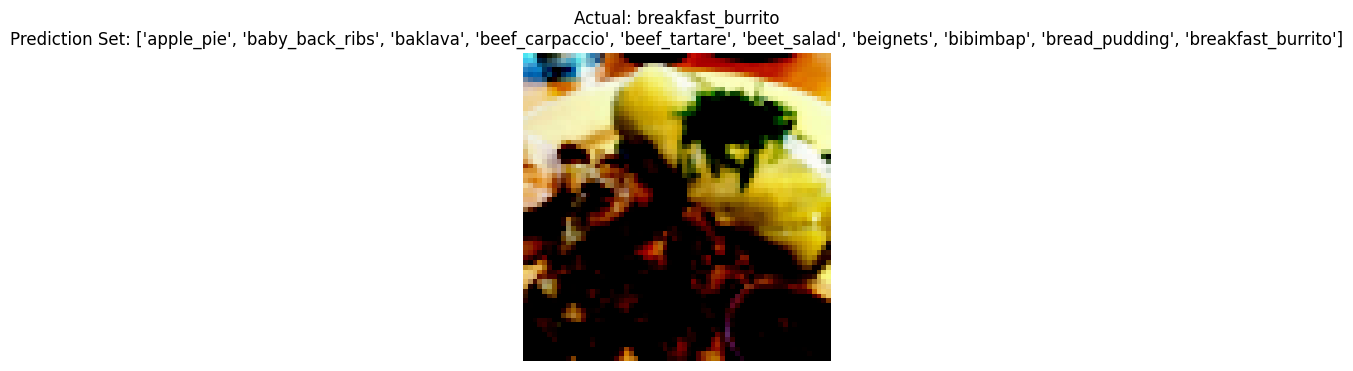

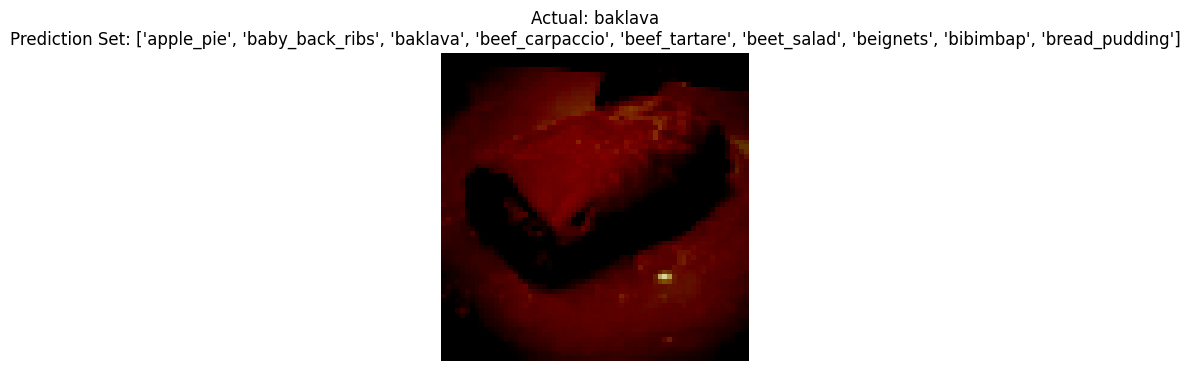

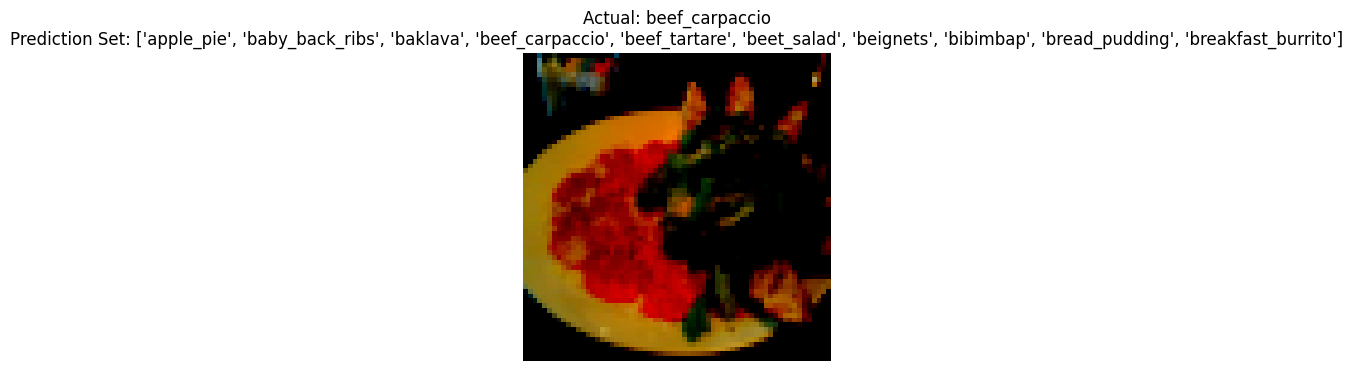

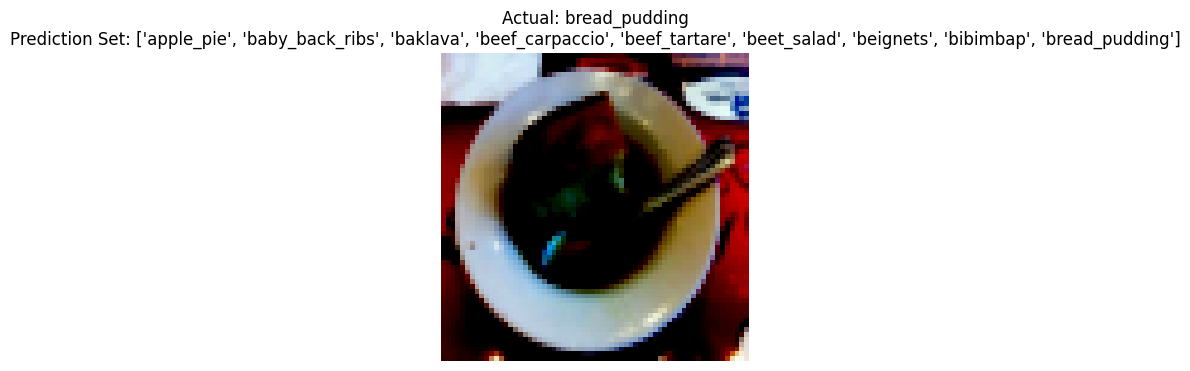

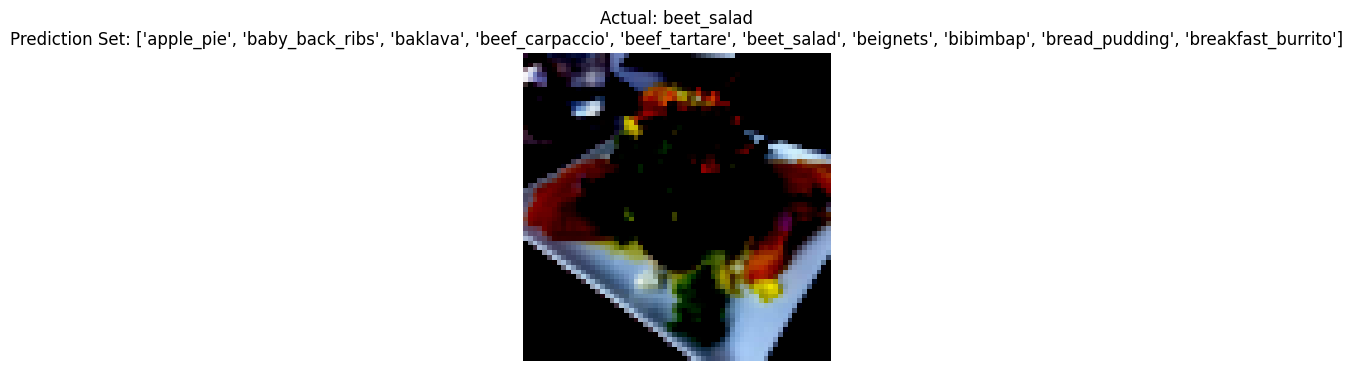

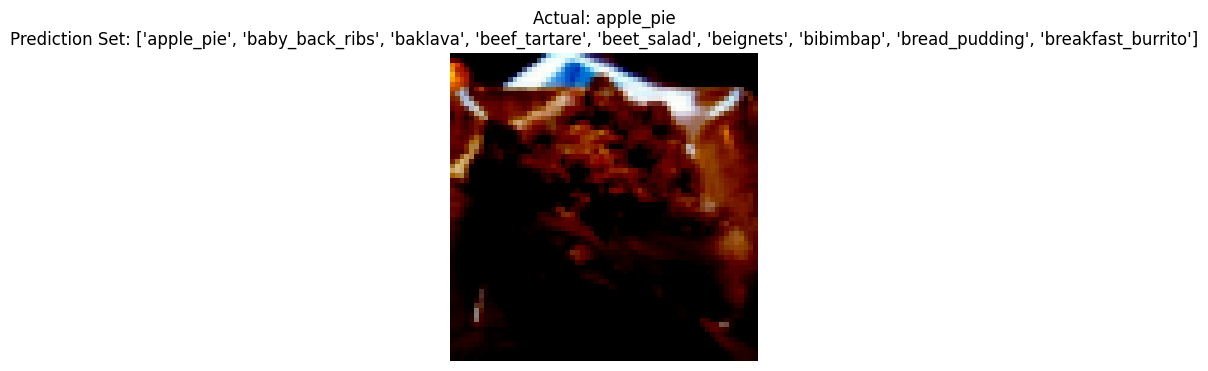

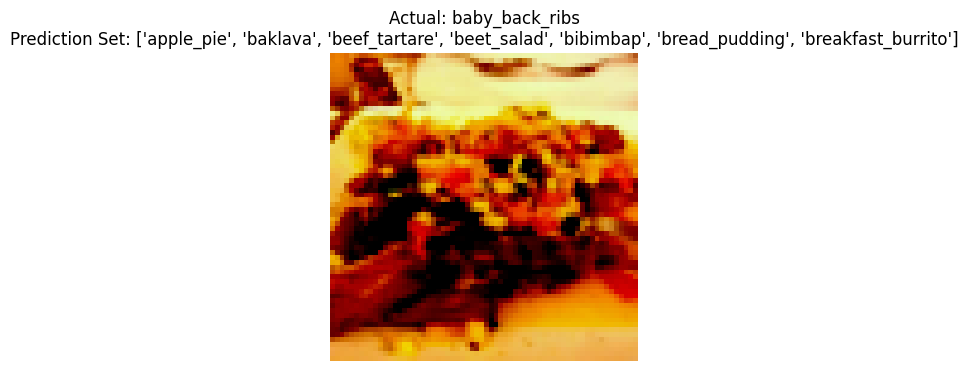

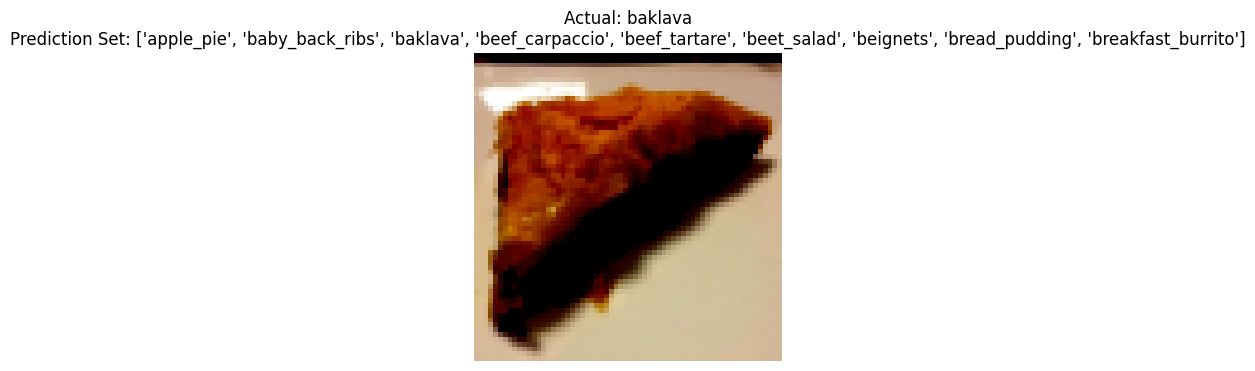

In [74]:
import matplotlib.pyplot as plt

prediction_sets = []
class_names = selected_classes = ['apple_pie', 'baby_back_ribs', 'baklava',
                    'beef_carpaccio', 'beef_tartare', 'beet_salad',
                    'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().permute(1,2,0))
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()

In [75]:
import numpy as np

n_classes = len(class_names)
confusion_matrix = np.zeros((n_classes, 2))

In [76]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()
with torch.inference_mode():
  for img, label in tqdm(test_loader):
      img = img.to(device)
      outputs = model(img)
      softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
      prediction_set = np.where(softmax_probs >= (1-qhat))[0]


      if label.item() in prediction_set:
          confusion_matrix[label, 0] += 1
      for idx in prediction_set:
          if idx != label.item():
              confusion_matrix[idx, 1] += 1


  0%|          | 0/2500 [00:00<?, ?it/s]

In [80]:
print(confusion_matrix)

[[ 242. 1917.]
 [ 243. 1687.]
 [ 245. 1873.]
 [ 226. 1460.]
 [ 237. 1914.]
 [ 249. 1837.]
 [ 243. 1652.]
 [ 244. 1705.]
 [ 234. 1860.]
 [ 241. 1799.]]


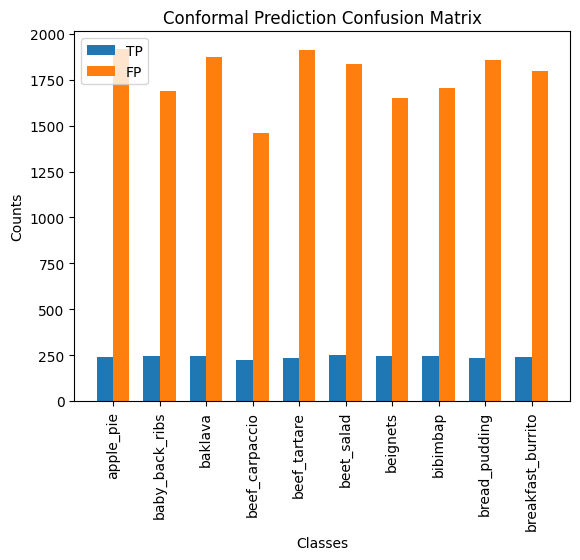

In [77]:
import matplotlib.pyplot as plt

bar_width = 0.35
index = np.arange(n_classes)
fig, ax = plt.subplots()
bar1 = ax.bar(index, confusion_matrix[:, 0], bar_width, label='TP')
bar2 = ax.bar(index + bar_width, confusion_matrix[:, 1], bar_width, label='FP')

ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Conformal Prediction Confusion Matrix')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_names, rotation=90)
ax.legend()

plt.show()